# **Methylation Biomarkers for Predicting Cancer**

## **Dimensionality Reduction: Principal Component Anlaysis**

**Author:** Meg Hutch

**Date:** January 24, 2020

**Objective:** Reduce dimensionality of the gene methylation data

In [17]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

Load Training and testing sets processed in R

In [18]:
# Training set
mcTrain = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTrain.csv')
# Testing set
mcTest = pd.read_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/mcTest.csv')

**Data Pre-Processing**

Check if any missing values: Nope!

In [19]:
mcTest.columns[mcTest.isna().any()].tolist()
mcTrain.columns[mcTest.isna().any()].tolist()

[]

## **Principal Component Analysis**

We will first conduct dimensionality reduction using principal component analysis

First, subset the training set to only include the methylated gene information

In [20]:
# remove non-gene data from both the training and testing sets
genesTrain = mcTrain.drop(columns=["diagnosis", "dilute_library_concentration", "age", "gender"])

genesTest = mcTest.drop(columns=["diagnosis", "dilute_library_concentration", "age", "gender"])

In [21]:
genesTest

,seq_num,OR4F5,AL627309.1,OR4F29,OR4F16,AL669831.1,AL645608.2,SAMD11,AL645608.1,NOC2L,...,KLHDC7B,SYCE3,CPT1B,CHKB-CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3,ACR,RABL2B
0,SEQF2357,1,27,0,0,3,9,168,0,211,...,40,88,1,27,112,120,152,1230,125,65
1,SEQF2564,0,42,0,0,11,14,183,0,222,...,58,89,0,16,121,115,125,1090,102,67
2,SEQF2341,3,28,0,0,7,22,156,0,240,...,48,119,0,27,142,132,167,1255,137,102
3,SEQF2522,0,47,0,0,12,18,258,0,387,...,51,131,0,31,163,200,221,1575,150,113
4,SEQF2598,0,35,0,0,5,11,202,0,269,...,67,115,0,26,143,197,178,1546,152,87
5,SEQF2438,1,1,0,0,0,1,6,0,13,...,5,7,0,1,10,8,8,59,5,3
6,SEQF2141,3,27,0,0,10,13,126,0,193,...,58,111,0,24,119,118,85,943,98,77
7,SEQF2580,0,21,0,0,6,8,149,0,183,...,39,80,0,20,81,105,133,798,79,82
8,SEQF2445,1,22,0,0,9,9,150,0,239,...,56,121,0,32,148,138,116,1107,95,89
9,SEQF2149,2,22,0,0,6,8,152,0,235,...,42,124,1,26,139,154,123,1081,115,91


Create patient seq_num id index

In [22]:
## Training set
# Convert patinet_ids to row names first
genesTrain = genesTrain.set_index(genesTrain.seq_num)

# Remove seq_num as a column
genesTrain = genesTrain.drop(columns=["seq_num"])

# Create a list of row names
patients = list(genesTrain.index)

## Testing set
# Convert patinet_ids to row names first
genesTest = genesTest.set_index(genesTest.seq_num)

# Remove seq_num as a column
genesTest = genesTest.drop(columns=["seq_num"])

# Create a list of row names
patientsTest = list(genesTest.index)

1) Standardize Dataset

Must scale features in your data before applying PCA. **StandardScaler** helps standardize features onto unit scale (mean = 0 and standard deviation = 1). Thus, each value in the dataset will have the sample mean value subtracted and then divided by the standard deviation of the whole dataset. 


In [23]:
# pca packages
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

# convert integer type to float
cols = genesTrain.columns

#genesTrain[cols] = genesTrain[cols].astype(np.float)
#genesTest[cols] = genesTest[cols].astype(np.float)

# Stanardize/Scale the data
x = StandardScaler().fit_transform(genesTrain)
xTest = StandardScaler().fit_transform(genesTest)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


**Let's check whether the normalized data has a mean of zero and a standard deviation of 1**

In [24]:
np.mean(x), np.std(x)

(-7.303468988602816e-19, 0.9613744523838432)

**Convert the normalized features into tabular format**

In [25]:
# Create list of column names
features = list(genesTrain.columns.values) 

# Create data frame of newly normalized data - use patients IDs as the index 
x = pd.DataFrame(x, columns = features, index = patients)

2) Determine Prinicpal Components

Reference: https://stackoverflow.com/questions/42167907/understanding-scikitlearn-pca-transform-function-in-python

**pca.fit** allows PCA function to compute vectors that you can project your data onto in order to reduce the dimension of your data.

**pca.transform** actually performs the projection. It projects each row of data into the vector space that was learned when fit was called.

from sklearn: **fit_transform**: Fit the model with X and apply the dimensionality reduction on X

In [26]:
## Define pca function
pca = PCA()

# Fit to the scaled/standardized data - then use transform to prokect into the new vector space learned by fit
principalComponents = pca.fit_transform(x)

# Generate a list of column names with the number for each prinicpal component 
col_names = [f'pc{i}' for i in range(1, 239)] # there are 238 samples - so we want to have range of 1 less than 239 column names 

# Add column names to the principal component dataset 
principalDf_ALL = pd.DataFrame(principalComponents, columns = col_names, index = patients)

**3) Determine # of Components and Variance**

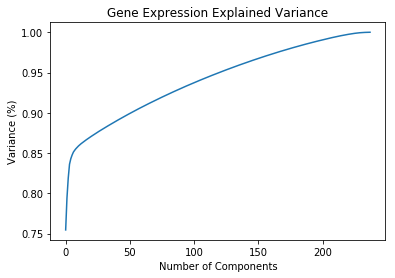

In [27]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Gene Expression Explained Variance')
plt.show()

**Alternative method - Pre-selecting % of variance**

When we fit the PCA classifier and transform x after specifying 90%, we get 52 principal components representing 90% of the variance.

In [28]:
pca = PCA(0.9)
genesTrain_transformed = pca.fit_transform(x)

# Define new pc column names (up to pc52)
col_names = [f'pc{i}' for i in range(1, 53)] 

# Add column names to the principal component dataset 
genesTrain_transformed = pd.DataFrame(genesTrain_transformed, columns = col_names, index = patients)

**Scree Plot**

View which principal components contribute most to the variance 

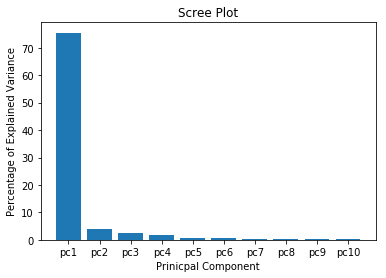

In [29]:
# remove PC from 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = per_var[:10] #top 10 PC - this number is chosen just so that we can more easily view the plot
labels = col_names[:10]

plt.bar(x=range(1, len(per_var)+1), height = per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Prinicpal Component')
plt.title('Scree Plot')
plt.show()

4) Project prinicipal components from the training set, to the test set

In [30]:
genesTest_transformed = pca.transform(genesTest)

When converted to a dataframe, we can see that the test set has been transformed into 52 principal components

In [31]:
genesTest_transformed = pd.DataFrame(data = genesTest_transformed, columns = col_names, index = patientsTest)
genesTest_transformed

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52
SEQF2357,-79426.322124,-16158.089156,16484.743730,-6839.756809,-6287.846484,11487.659797,-4786.160919,-2909.766979,-9782.260176,-7558.638964,...,1248.458252,1710.059318,1638.782910,1304.329702,-1877.988070,-137.693090,268.168471,1066.840844,-4622.582948,3128.019506
SEQF2564,-69003.283478,-10748.915138,10923.433412,-7615.907458,-6788.093872,8785.810183,-3810.417643,-1926.143030,-8649.109257,-6232.398910,...,1161.843840,1497.889476,1576.260853,1048.851937,-1986.132744,112.232056,100.831378,973.912946,-4037.947442,2815.293335
SEQF2341,-97829.614008,-15167.452732,25902.738635,-9707.671397,-9321.340635,11456.144706,-7256.951677,-3223.444334,-13827.584105,-8746.772214,...,1427.057047,2245.223854,1778.063006,1467.645318,-2227.614994,134.723102,128.072078,1400.446983,-5473.345676,3636.683901
SEQF2522,-106072.978692,-6490.451312,21232.311114,-13125.510417,-10634.425328,13533.791830,-7921.887815,-2540.418172,-15206.725611,-10000.231436,...,1425.709926,2605.255493,2414.685786,1104.267324,-3039.477621,486.647318,110.545679,1603.529105,-6173.253196,4111.443245
SEQF2598,-93056.667670,-20372.157058,18163.941049,-10488.871063,-8409.894397,12087.000841,-6792.427153,-2867.834189,-12213.166958,-7814.791809,...,1638.479505,1898.811203,2027.854746,1542.328581,-2338.784929,58.776982,260.935889,1304.139143,-5533.528825,3641.960283
SEQF2438,-4479.531958,-328.968053,1197.994581,-558.539822,401.149895,61.867974,-28.354110,-159.484461,-679.633559,-334.318927,...,24.217153,107.632003,114.642247,85.009429,-136.855401,2.037668,41.684207,46.594728,-226.699366,159.141433
SEQF2141,-73500.434470,-15687.543975,17202.309747,-7685.056531,-6803.487827,9390.448082,-4470.290777,-2648.631762,-9386.989414,-6015.697572,...,1172.575289,1606.223356,1454.850840,1172.766572,-1752.183430,84.052849,230.843751,1036.693053,-4268.229022,2841.909794
SEQF2580,-61689.438951,-10108.462061,13213.961718,-2054.803239,-5732.568327,6340.755421,-5162.255140,-1760.732678,-8152.859575,-5376.658924,...,1079.114581,1424.903651,1177.893270,815.045895,-1556.666510,88.438391,64.337399,936.121874,-3519.235654,2420.733438
SEQF2445,-90525.720138,-18458.900729,24846.572095,-9570.018737,-8668.779473,10175.477100,-8111.692137,-2924.173567,-11455.964177,-8203.346846,...,1400.503476,2126.871517,1410.646037,1426.135086,-2002.168157,56.527980,74.653430,1414.547017,-5168.545576,3394.159713
SEQF2149,-88220.159700,-22149.598946,21474.141774,-9082.025051,-9503.005979,11272.756473,-6999.335396,-2901.480959,-10181.666816,-7829.220144,...,1602.105173,1941.880928,1434.512994,1326.755111,-1971.888677,-143.946576,188.667440,1369.512877,-5158.170941,3394.093389


**Save PCA Components**

In [32]:
principalDf_ALL.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/principalDF_ALL.csv')
genesTrain_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/genesTrain_transformed.csv')
genesTest_transformed.to_csv('C:\\Users\\User\\Box Sync/Projects/Multi_Cancer_DL/02_Processed_Data/genesTest_transformed.csv')